#Main

Ingrese el periodo movil 7
Ingrese el periodo de rebalanceo1


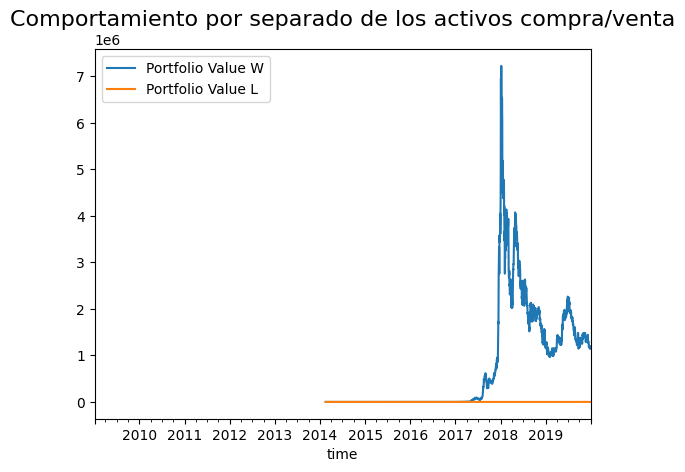

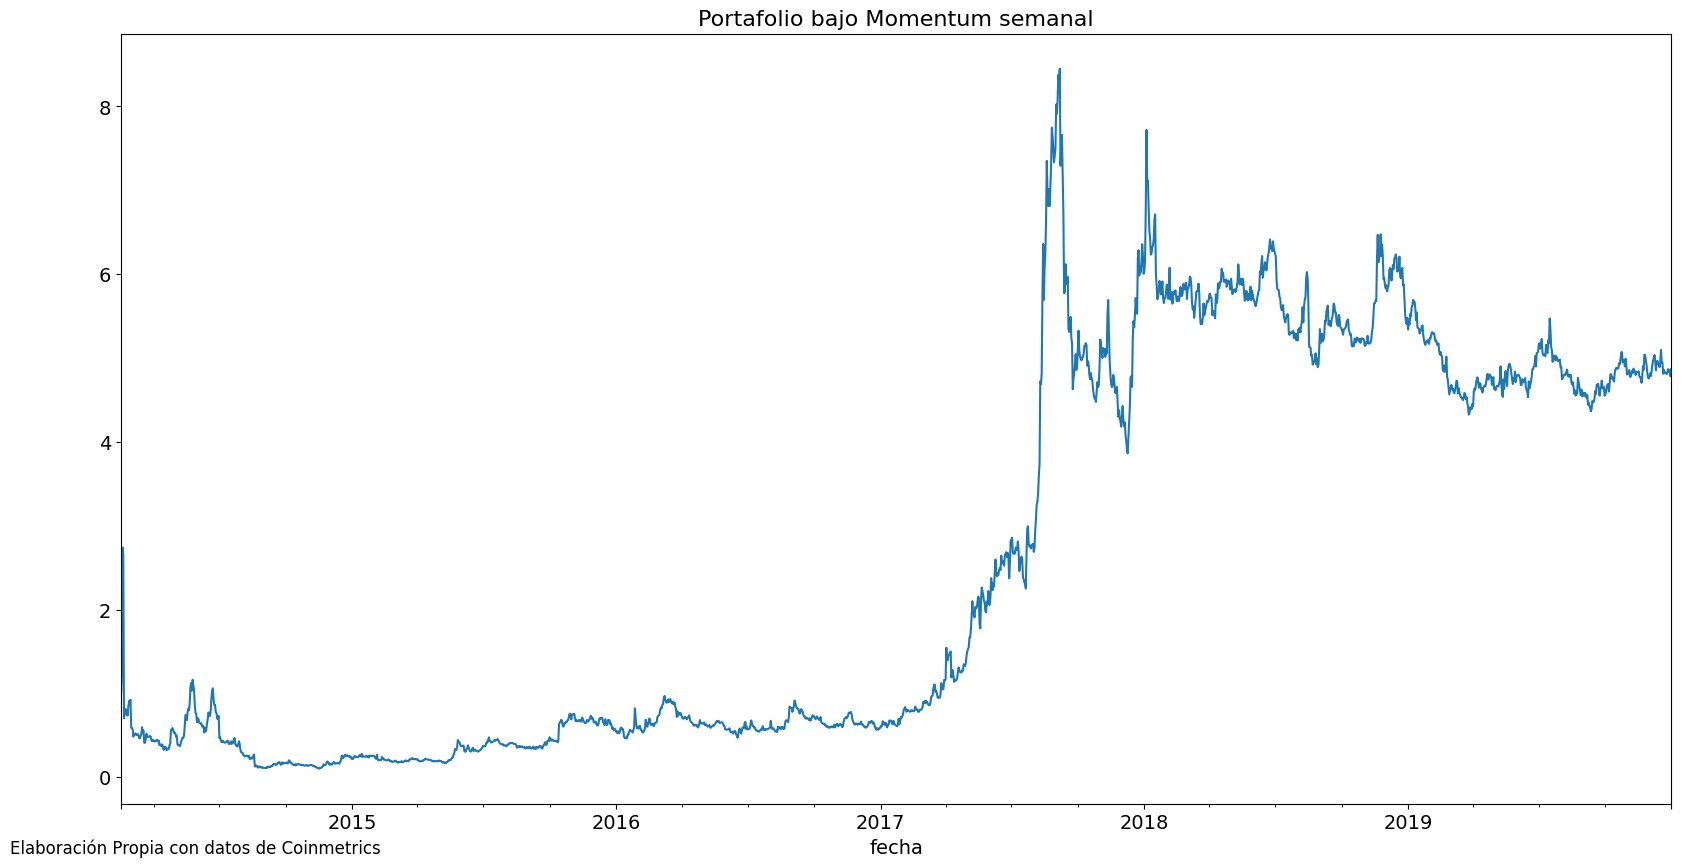

metricas estadisticas de los portafolios 0.9095006935267915 1.1231820671039778 0.8097535743887505 3.1538029360687805


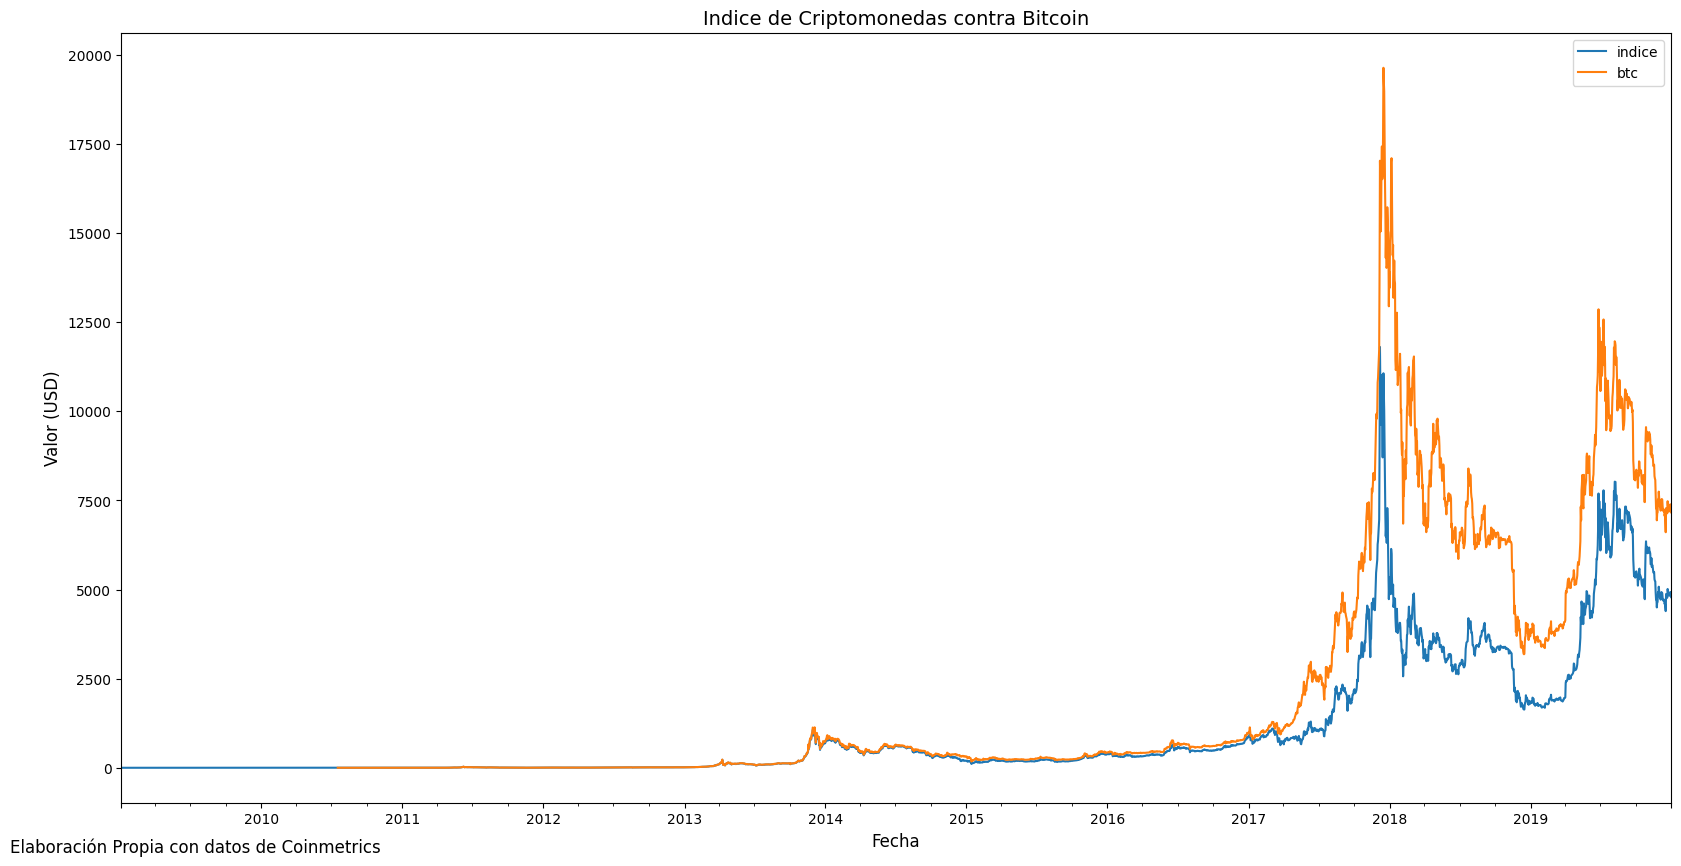

portfolio: 0.9095006935267913 1.123182067103978 0.8097535743887502 indice: 0.7605666080780433 0.8613442466623031 0.8829995800462223 0.5629664396457938
..............................
 modelo de regresion CAPM 

<bound method Summary.as_latex of <class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
Dep. Variable:                  rp_rf   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     6.199
Date:                Mon, 24 Jul 2023   Prob (F-statistic):             0.0129
Time:                        06:50:02   Log-Likelihood:                 2212.0
No. Observations:                1479   AIC:                            -4420.
Df Residuals:                    1477   BIC:                            -4409.
Df Model:                           1                                       

<ipython-input-129-74ebe60e1ce9>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  famma_week_1.replace(np.inf,np.nan,inplace=True)


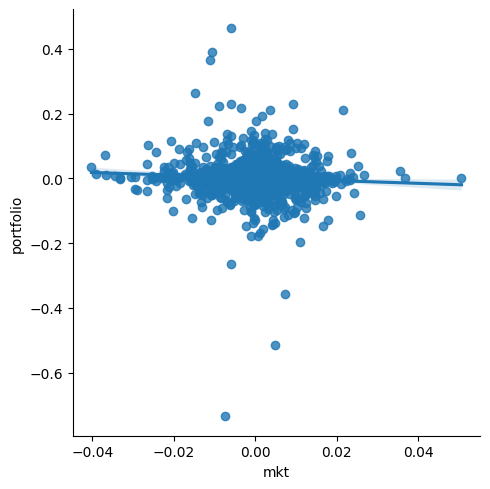

In [133]:

import pandas as pd
import numpy as np
from scipy.stats import percentileofscore as score
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf


main()



In [130]:


def find_data():
    prices_bef_covi = pd.read_csv('prices_momentum_final.csv', index_col='time', parse_dates=True)
    return prices_bef_covi



def main():
    #ingreso parametros
    mom_period = input('Ingrese el periodo movil ')
    mom_period = int(mom_period)
    rebal_freq= input('Ingrese el periodo de rebalanceo')
    rebal_freq = int(rebal_freq)

    #Asignar el cambio porcentual
    prices_bef_covi = find_data()
    prices_pct_week = prices_bef_covi.pct_change(periods=mom_period)
    prices_pct_week.to_csv('prices_pct_week.csv')
    ranks(rebal_freq,prices_pct_week, prices_bef_covi )


def ranks(rebal, prices_pct_week,prices_bef_covi):
    #rankeo
    ranks = pd.DataFrame(columns=prices_bef_covi.columns, index=prices_bef_covi.index)

    for i in range(len(prices_pct_week)):
        if i % rebal == 0:
            ranks.iloc[i] = prices_pct_week.iloc[i].rank(axis=0, method="first", ascending=False)

    ranks.to_csv('ranks.csv')
    ranks_order = ranks.sort_values(by=list(prices_pct_week.columns), na_position='last')
    ranks_order.to_csv('ranksorder.csv')



    ranks = ranks.shift(periods=1, axis=0)
    ranks.ffill(inplace=True)

    #sacar long y short del 20%
    prices_nan = prices_bef_covi.copy()
    prices_nan['sum'] = ranks.nunique(axis=1)

    prices_nan['quintile'] = np.floor((prices_nan['sum'] / 5))
    prices_nan['ranks'] = ranks.count(axis=1)
    n_long = prices_nan['quintile']
    n_short = prices_nan['quintile']
    n_coins = prices_nan['ranks'] - n_short + 1

    for col in ranks.columns:
        ranks.loc[ranks[col] <= n_long, col] = 1
        ranks.loc[ranks[col] >= n_coins, col] = -1
        ranks.loc[(ranks[col] < n_coins) & (ranks[col] > n_long), col] = None

    WandL(ranks,prices_bef_covi,n_long, n_short)

    Time(ranks,prices_bef_covi,n_long, n_short)







# Graficas Portafolio



In [131]:
from operator import mul
def WandL(rank,prices_bef_covi,n_long, n_short):

    winners = rank.replace(-1.0, np.nan)
    lossers = rank.replace(1.0, np.nan)

    win_port = (prices_bef_covi.pct_change()) * winners
    los_port = (prices_bef_covi.pct_change()) * lossers.replace(-1.0, 1.0)

    win_port['ret'] = win_port.sum(axis=1, skipna=True)/ n_long
    los_port['ret'] = los_port.sum(axis=1, skipna=True)/n_short

    win_port['Portfolio Value W'] = ((win_port['ret'] + 1).cumprod())
    los_port['Portfolio Value L'] = ((los_port['ret'] + 1).cumprod())

    win_port['Portfolio Value W'].plot()
    los_port['Portfolio Value L'].plot()
    plt.legend()
    plt.title('Comportamiento por separado de los activos compra/venta',fontsize=16)
    dif = win_port['ret'] - los_port['ret']
    dif.mean(), win_port['ret'].mean() * 365, los_port['ret'].mean() * 365
    t_stat(win_port['ret'],los_port['ret'])


def t_stat(x,y):
    meanx=x.mean()
    varx=x.std()**2
    meany=y.mean()
    vary=y.std()**2
    nx=x.count()
    ny=y.count()
    t=(meanx-meany)/np.sqrt(varx/nx+vary/ny)
    return t

def Time(rank,prices_bef_covi,n_long, n_short):
  %matplotlib inline
  mult_df=(prices_bef_covi.pct_change())*rank

  mult_df['Total Return']=(mult_df.sum(axis=1,skipna=True))/(n_long+n_short)
  mult_df=mult_df['2014-02-15':]

  mult_df['Portfolio Value']=((mult_df['Total Return'] +1).cumprod())


  mult_df.loc['2014-02-15','Portfolio Value']=1
  mult_df1=mult_df.dropna(how="all")
  fecha= mult_df1.index.values[1]


  plt.figure(figsize=(20,10))
  mult_df['Portfolio Value'].plot(kind='line',fontsize=14)
  plt.title('Portafolio bajo Momentum semanal',fontsize=16)
  plt.xlabel('fecha',fontsize=14)
  plt.annotate('Elaboración Propia con datos de Coinmetrics', (0,0), (-80,-25), fontsize=12,
              xycoords='axes fraction', textcoords='offset points', va='top')
  plt.show()
  #metricas estadisticas de los portafolios

  sharpe_mean=mult_df['Total Return'].mean()*365
  sharpe_std=mult_df['Total Return'].std()*np.sqrt(365)
  sharpe=sharpe_mean/sharpe_std
  skew=mult_df['Total Return'].skew()

  print('metricas estadisticas de los portafolios', sharpe_mean,sharpe_std,sharpe,skew)

  index_df = mainmkt(mult_df)
  fammaport(mult_df,index_df,fecha)





# MKT CAP INDEX

In [111]:
def find_data2():
    index_df= pd.read_csv('crypto_index.csv', index_col='time', parse_dates=True)
    return index_df
def mainmkt(mult_df):
  index_df = find_data2()
  prices_bef_covi = find_data()
  index_df['indice'].plot(figsize=(20,10))
  prices_bef_covi['btc'].plot()

  plt.title('Indice de Criptomonedas contra Bitcoin',fontsize=14)
  plt.xlabel('Fecha',fontsize=12)
  plt.ylabel('Valor (USD)',fontsize=12)
  plt.legend()
  plt.annotate('Elaboración Propia con datos de Coinmetrics', (0,0), (-80,-25), fontsize=12,
              xycoords='axes fraction', textcoords='offset points', va='top')
  plt.show()
  #El sharpe ratio del indice
  index_df['2014-08-02':]['indice'].pct_change().mean()/index_df['2014-08-02':]['indice'].pct_change().std()

  #comparaciones del portafolio vs el indice del mercado, las fechas se cambian de acuerdo al portafolio

  port_er=mult_df['Portfolio Value'].pct_change().mean()*365
  port_vol=mult_df['Portfolio Value'].pct_change().std()*np.sqrt(365)

  index_er=index_df['08-02-2014':]['indice'].pct_change().mean()*365
  index_vol=index_df['08-02-2014':]['indice'].pct_change().std()*np.sqrt(365)

  sharpe_port=port_er/port_vol
  sharpe_ind=index_er/index_vol
  ind_skew=index_df['08-02-2014':]['indice'].pct_change().skew()

  print('portfolio:', port_er,port_vol,sharpe_port,'indice:', index_er,index_vol,sharpe_ind, ind_skew)
  return index_df


# Regresiones

In [129]:

def find_data3():
    famma=pd.read_csv('F-F_Research_Data_5_Factors_2x3_daily.CSV',index_col='date',parse_dates=True)
    return famma

def fammaport(mult_df,index_df,fecha):
  famma = find_data3()
  famma_week=famma.copy()/100
  famma_week['portfolio']=mult_df['Portfolio Value'].pct_change()
  famma_week['crypto_mkt']=index_df['indice'].pct_change()

  #cambiar las fechas en cada portfolio
  #dropear en donde este vacio



  famma_week_1=famma_week[fecha:'2019-12-31']
  famma_week_1.replace(np.inf,np.nan,inplace=True)
  famma_week_1=famma_week_1.fillna(0)
  famma_week_1['rp_rf']=famma_week_1['portfolio']-famma_week_1['RF']
  famma_week_1.rename(columns={'Mkt-RF':'mkt_rf'},inplace=True)
  famma_week_1['mkt']=famma_week_1['mkt_rf']+famma_week_1['RF']
  famma_week_1['ci_rf']=famma_week_1['crypto_mkt']-famma_week['RF']

  regrCAPM(famma_week_1)
  regrindp(famma_week_1)
  regr3f(famma_week_1)
  regr5f(famma_week_1)
  regr6f(famma_week_1)
  sns.lmplot(data=famma_week_1,x='mkt',y='portfolio')

#regresion CAPM
def regrCAPM(famma_week_1):
  model_week= smf.ols('rp_rf ~ mkt_rf ', data=famma_week_1)
  results_week=model_week.fit(cov_type='HC3')
  print('..............................\n modelo de regresion CAPM \n')
  print(results_week.summary().as_latex)

#regresion vs indic propio
def regrindp(famma_week_1):
  model_week= smf.ols('rp_rf ~ ci_rf ', data=famma_week_1)
  results_week=model_week.fit(cov_type='HC3')
  print('..............................\n modelo de regresion vs indic propio\n')
  print(results_week.summary().as_latex)

# regresion 3 factores
def regr3f(famma_week_1):
  model_week= smf.ols('rp_rf ~ mkt_rf + SMB + HML', data=famma_week_1)
  results_week=model_week.fit(cov_type='HC3')
  print('..............................\n modelo de 3 factores sin tasa libre de riesgo\n')
  print(results_week.summary().as_latex)

#regresion 5 factores
def regr5f(famma_week_1):
  model_week= smf.ols('rp_rf ~ mkt_rf + SMB + HML + RMW + CMA', data=famma_week_1)
  results_week=model_week.fit(cov_type='HC3')
  print('..............................\n modelo de 5 factores sin tasa libre de riesgo\n')
  print(results_week.summary().as_latex)
#modelo de 6 factores sin tasa libre de riesgo
def regr6f(famma_week_1):
  model_week= smf.ols('portfolio ~ crypto_mkt+ mkt + SMB + HML + RMW + CMA ', data=famma_week_1)
  results_week=model_week.fit(cov_type='HC3')
  print('..............................\n modelo de 6 factores sin tasa libre de riesgo\n')
  print(results_week.summary().as_latex)